In [2]:
# 02_backtests — FX Overlay & Portefeuille multi-devises (robuste NaN)
# --------------------------------------------------------------------
# Lit: signals_panel.csv (sortie du notebook signaux)
# - Patch 2: si hedge_cost inconnu => pas de hedge ce mois-là
# - Nettoyage NaN avant stats (fillna(0))
# --------------------------------------------------------------------

import pandas as pd
import numpy as np
from pathlib import Path
import os

def find_project_root(start=Path('.'), markers=("data", ".git", "pyproject.toml", "README.md")):
    p = Path(start).resolve()
    for _ in range(10):
        if any((p / m).exists() for m in markers):
            return p
        if p.parent == p:
            break
        p = p.parent
    return Path.cwd()

# DATA_DIR resolution
DATA_DIR = Path(os.environ.get('FX_DATA_DIR') or os.environ.get('DATA_DIR') or find_project_root() / 'data').expanduser().resolve()
print('Using DATA_DIR:', DATA_DIR)
SIG_FILE = DATA_DIR / 'signals_panel.csv'
if not SIG_FILE.exists():
    print('ERROR: signals_panel.csv not found at', SIG_FILE)
    if DATA_DIR.exists():
        print('Contents of', DATA_DIR, ':')
        for p in sorted([str(p) for p in DATA_DIR.iterdir()]):
            print(' -', p)
    else:
        print('DATA_DIR does not exist:', DATA_DIR)
    raise FileNotFoundError(f"signals_panel.csv not found at {SIG_FILE}. Set FX_DATA_DIR or place the file in {DATA_DIR}.")

SIG = pd.read_csv(SIG_FILE, parse_dates=["Date"])

# ---------------------- utilitaires ----------------------
def ann_mean(x, freq=12): return np.nanmean(x) * freq
def ann_vol(x, freq=12):  return np.nanstd(x, ddof=1) * np.sqrt(freq)
def sharpe(x, freq=12):
    mu = ann_mean(x, freq); sd = ann_vol(x, freq)
    return mu / sd if sd and not np.isnan(sd) else np.nan

def max_drawdown(cum):
    high = np.maximum.accumulate(cum)
    dd = cum / high - 1.0
    return dd.min()

def info_ratio(x, y, freq=12):
    diff = x - y
    mu = ann_mean(diff, freq)
    sd = ann_vol(diff, freq)
    return mu / sd if sd and not np.isnan(sd) else np.nan

def summary_stats(r, freq=12):
    cum = (1 + r).cumprod()
    return {"Ann. return": ann_mean(r, freq),
            "Ann. vol": ann_vol(r, freq),
            "Sharpe": sharpe(r, freq),
            "Max DD": max_drawdown(cum)}

# ------------------- paramètres bt ----------------------
TC_bps = 3.0     # coûts de transaction par variation de hedge (bps du notionnel)
CAP_DH = 0.5     # cap |Δh| / mois (50%)
freq = 12        # mensuel

# ----------------- préparation panel --------------------
SIG = SIG.sort_values(["pair","Date"])
# hedge ratio ffill pour éviter un trade à t0
SIG["HedgeRatio"] = SIG.groupby("pair")["HedgeRatio"].transform(lambda s: s.ffill())
SIG["R_FX"] = SIG["ret_1m"]                  # rendement FX (mensuel)
SIG["hedge_cost_1m"] = SIG["hedge_cost_1m"]  # déjà = rate_base - rate_fore

# --------- Patch 2: pas de hedge si coût inconnu ----------
def fx_overlay_pair(df_pair, tc_bps=TC_bps, cap_dh=CAP_DH):
    df = df_pair.copy().sort_values("Date")

    # Hedge prévu
    h_raw = df["HedgeRatio"].clip(0, 1).fillna(0.0)
    carry_cost = df["hedge_cost_1m"]  # peut contenir NaN
    known = carry_cost.notna()

    # Ne couvre pas quand coût inconnu
    h = h_raw.where(known, 0.0)

    # Cap sur Δh
    dh = h.diff().fillna(0).clip(-cap_dh, cap_dh)
    h_cap = h.shift(1).fillna(h.iloc[0]) + dh
    h_cap = h_cap.clip(0, 1)

    # Remplacements neutres
    carry_cost = carry_cost.fillna(0.0)   # neutre car h_cap = 0 ces mois-là
    r_fx = df["R_FX"].fillna(0.0)
    tc = (tc_bps/10000.0) * dh.abs()

    # P&L
    pnl_dyn = (1 - h_cap)*r_fx - h_cap*carry_cost - tc

    # Benchmarks
    pnl_0 = r_fx
    pnl_100 = -carry_cost  # coût uniquement

    res = pd.DataFrame({
        "Date": df["Date"].values,
        "pair": df["pair"].values,
        "pnl_dyn": pnl_dyn.values,
        "pnl_0": pnl_0.values,
        "pnl_100": pnl_100.values,
        "h_used": h_cap.values,
        "dh": dh.values,
        "tc": tc.values
    })
    return res

# --------------- backtest par paire ---------------------
fx_results = []
for pair, g in SIG.groupby("pair"):
    fx_results.append(fx_overlay_pair(g))
fx_results = pd.concat(fx_results).sort_values(["pair","Date"])

# Nettoyage final pour stats
for col in ["pnl_dyn","pnl_0","pnl_100"]:
    fx_results[col] = fx_results[col].fillna(0.0)

# Résumé par paire
rows = []
for pair, g in fx_results.groupby("pair"):
    s_dyn = summary_stats(g["pnl_dyn"])
    s_0   = summary_stats(g["pnl_0"])
    s_100 = summary_stats(g["pnl_100"])
    ir_vs_0   = info_ratio(g["pnl_dyn"], g["pnl_0"])
    ir_vs_100 = info_ratio(g["pnl_dyn"], g["pnl_100"])
    rows.append({
        "pair": pair,
        "dyn_ret": s_dyn["Ann. return"], "dyn_vol": s_dyn["Ann. vol"], "dyn_Sharpe": s_dyn["Sharpe"], "dyn_MDD": s_dyn["Max DD"],
        "0_ret": s_0["Ann. return"],     "0_vol": s_0["Ann. vol"],     "0_Sharpe": s_0["Sharpe"],
        "100_ret": s_100["Ann. return"], "100_vol": s_100["Ann. vol"], "100_Sharpe": s_100["Sharpe"],
        "IR_vs_0": ir_vs_0, "IR_vs_100": ir_vs_100,
        "avg_turnover_%": 100 * g["dh"].abs().mean()
    })
pair_summary = pd.DataFrame(rows).sort_values("pair")

# -------- portefeuille multi-devises ----------
fx_weights = {"EURUSD":0.5, "EURGBP":0.2, "EURCHF":0.2, "EURJPY":0.1}
w = pd.Series(fx_weights)

port = (fx_results.set_index(["Date","pair"])
                  .join(w.rename("w"), on="pair")
                  .fillna({"w":0.0}))
port["p_dyn_w"]  = port["pnl_dyn"] * port["w"]
port["p_0_w"]    = port["pnl_0"]   * port["w"]
port["p_100_w"]  = port["pnl_100"] * port["w"]

port_daily = port.groupby("Date")[["p_dyn_w","p_0_w","p_100_w"]].sum().reset_index()
port_daily = port_daily.sort_values("Date").rename(columns={"p_dyn_w":"R_dyn","p_0_w":"R_0","p_100_w":"R_100"})

# Résumé portefeuille
S_dyn = summary_stats(port_daily["R_dyn"])
S_0   = summary_stats(port_daily["R_0"])
S_100 = summary_stats(port_daily["R_100"])
IR0   = info_ratio(port_daily["R_dyn"], port_daily["R_0"])
IR100 = info_ratio(port_daily["R_dyn"], port_daily["R_100"])

portfolio_summary = pd.DataFrame([{
    "dyn_ret": S_dyn["Ann. return"], "dyn_vol": S_dyn["Ann. vol"], "dyn_Sharpe": S_dyn["Sharpe"], "dyn_MDD": S_dyn["Max DD"],
    "0_ret": S_0["Ann. return"],     "0_vol": S_0["Ann. vol"],     "0_Sharpe": S_0["Sharpe"],
    "100_ret": S_100["Ann. return"], "100_vol": S_100["Ann. vol"], "100_Sharpe": S_100["Sharpe"],
    "IR_vs_0": IR0, "IR_vs_100": IR100
}])

# --------------------- exports --------------------------
OUT_DIR = DATA_DIR
pair_summary.to_csv(OUT_DIR / "bt_fx_pair_summary.csv", index=False)
fx_results.to_csv(OUT_DIR / "bt_fx_pair_timeseries.csv", index=False)
portfolio_summary.to_csv(OUT_DIR / "bt_portfolio_summary.csv", index=False)
port_daily.to_csv(OUT_DIR / "bt_portfolio_timeseries.csv", index=False)

print("[OK] Résumés écrits :")
print(" -", OUT_DIR / "bt_fx_pair_summary.csv")
print(" -", OUT_DIR / "bt_fx_pair_timeseries.csv")
print(" -", OUT_DIR / "bt_portfolio_summary.csv")
print(" -", OUT_DIR / "bt_portfolio_timeseries.csv")

# ---------------- affichage console ---------------------
print("\n=== Résumé par paire (extrait) ===")
print(pair_summary.round(3))
print("\n=== Résumé portefeuille ===")
print(portfolio_summary.round(3))


Using DATA_DIR: H:\Documents\Python\Projet FX\FX_Scoreboard_Project\data
[OK] Résumés écrits :
 - H:\Documents\Python\Projet FX\FX_Scoreboard_Project\data\bt_fx_pair_summary.csv
 - H:\Documents\Python\Projet FX\FX_Scoreboard_Project\data\bt_fx_pair_timeseries.csv
 - H:\Documents\Python\Projet FX\FX_Scoreboard_Project\data\bt_portfolio_summary.csv
 - H:\Documents\Python\Projet FX\FX_Scoreboard_Project\data\bt_portfolio_timeseries.csv

=== Résumé par paire (extrait) ===
     pair  dyn_ret  dyn_vol  dyn_Sharpe  dyn_MDD  0_ret  0_vol  0_Sharpe  \
0  EURCHF    1.633    1.875       0.871   -1.000 -0.020  0.059    -0.341   
1  EURGBP   14.357    5.247       2.736   -0.069  0.008  0.074     0.106   
2  EURJPY    0.491    0.331       1.482   -0.949  0.010  0.111     0.090   
3  EURUSD   11.614    4.123       2.817   -0.083  0.000  0.094     0.002   

   100_ret  100_vol  100_Sharpe  IR_vs_0  IR_vs_100  avg_turnover_%  
0    4.511    3.918       1.151    0.882     -1.093           2.795  
1   25

In [3]:
# ================================
# 03 — Walk-forward OUT-OF-SAMPLE
# ================================

import numpy as np
import pandas as pd

# ---- paramètres OOS ----
WINDOW_YEARS = 5
FREQ = 12
WINDOW_MONTHS = WINDOW_YEARS * FREQ
Q_LOW, Q_HIGH = 0.25, 0.75
TC_bps_OOS = TC_bps    # même coûts que l'IS
CAP_DH_OOS = CAP_DH    # même cap que l'IS

# (On repart du SIG déjà chargé/trié dans ta session)
SIG_OOS = SIG.sort_values(["pair", "Date"]).copy()

def walkforward_pair(df_pair: pd.DataFrame,
                     win_m=WINDOW_MONTHS, ql=Q_LOW, qh=Q_HIGH,
                     tc_bps=TC_bps_OOS, cap_dh=CAP_DH_OOS):
    """
    OOS strict:
      - Calibrage des seuils sur [t-win_m, t-1]
      - Décision au mois t
      - Application du hedge et P&L sur le mois t+1 (ret & hedge_cost décalés)
      - Prudence: si hedge_cost[t+1] inconnu => pas de hedge ce mois-là
      - Cap sur Δh
    """
    df = df_pair.sort_values("Date").reset_index(drop=True).copy()
    n = len(df)

    # Pré-alloc
    hedge_dec = np.full(n, np.nan)   # décision à t (0/0.5/1)
    hedge_used = np.full(n, np.nan)  # hedge effectif appliqué sur t+1 après cap
    dh_list = np.full(n, 0.0)
    tc_list = np.full(n, 0.0)
    pnl_dyn = np.zeros(n)
    pnl_0   = np.zeros(n)
    pnl_100 = np.zeros(n)

    score = df["FX_Score"].values
    r_fx  = df["ret_1m"].fillna(0.0).values
    hc    = df["hedge_cost_1m"].values  # peut être NaN

    # On initialise h_prev à 0 la première fois qu’on agit
    h_prev = 0.0

    # Boucle: décision à t, application sur t+1
    # On s’arrête à n-2 car on a besoin de t+1
    for t in range(win_m, n-1):
        train_scores = pd.Series(score[t-win_m:t]).dropna()
        if len(train_scores) < max(24, int(0.5*win_m)):
            continue

        thr_dn = train_scores.quantile(ql)
        thr_up = train_scores.quantile(qh)

        s_t = score[t]
        if np.isnan(s_t):
            h_raw = 0.0
        elif s_t >= thr_up:
            h_raw = 0.0
        elif s_t <= thr_dn:
            h_raw = 1.0
        else:
            h_raw = 0.5

        # Coût et rendement du mois SUIVANT
        hc_next = hc[t+1]
        r_next  = r_fx[t+1]

        # Prudence: si coût inconnu à t+1, on ne hedge pas ce mois-là
        h_safe = h_raw if not np.isnan(hc_next) else 0.0

        # Cap sur Δh (vs hedge effectif précédent)
        dh = np.clip(h_safe - h_prev, -cap_dh, cap_dh)
        h_eff = np.clip(h_prev + dh, 0.0, 1.0)

        # Coût transac
        tc = (tc_bps/10000.0) * abs(dh)

        # P&L du mois t+1 avec hedge décidé à t
        hc_eff = 0.0 if np.isnan(hc_next) else hc_next
        pnl_dyn[t+1] = (1 - h_eff)*r_next - h_eff*hc_eff - tc
        pnl_0[t+1]   = r_next
        pnl_100[t+1] = -hc_eff

        hedge_dec[t]   = h_raw
        hedge_used[t+1]= h_eff
        dh_list[t+1]   = dh
        tc_list[t+1]   = tc
        h_prev = h_eff  # pour le mois suivant

    out = df.copy()
    out["Hedge_decision_oos"] = hedge_dec
    out["Hedge_used_oos"]     = hedge_used
    out["dh_oos"]             = dh_list
    out["tc_oos"]             = tc_list
    out["pnl_dyn_oos"]        = pnl_dyn
    out["pnl_0_oos"]          = pnl_0
    out["pnl_100_oos"]        = pnl_100
    # Remplissages neutres éventuels
    out[["pnl_dyn_oos","pnl_0_oos","pnl_100_oos"]] = out[["pnl_dyn_oos","pnl_0_oos","pnl_100_oos"]].fillna(0.0)
    return out

# ---- exécution par paire ----
oos_list = []
for pair, g in SIG_OOS.groupby("pair"):
    oos_list.append(walkforward_pair(g))
OOS = pd.concat(oos_list).sort_values(["pair","Date"])

# ---- statistiques par paire ----
def ann_mean(x, freq=12): return np.nanmean(x) * freq
def ann_vol(x, freq=12):  return np.nanstd(x, ddof=1) * np.sqrt(freq)
def sharpe(x, freq=12):
    mu = ann_mean(x, freq); sd = ann_vol(x, freq)
    return mu / sd if sd and not np.isnan(sd) else np.nan
def max_drawdown(cum):
    high = np.maximum.accumulate(cum)
    return (cum / high - 1.0).min()
def info_ratio(x, y, freq=12):
    diff = x - y
    mu = ann_mean(diff, freq); sd = ann_vol(diff, freq)
    return mu / sd if sd and not np.isnan(sd) else np.nan

rows = []
for pair, g in OOS.groupby("pair"):
    dyn = g["pnl_dyn_oos"].values
    b0  = g["pnl_0_oos"].values
    b1  = g["pnl_100_oos"].values
    S_dyn = {"ret": ann_mean(dyn), "vol": ann_vol(dyn), "sh": sharpe(dyn),
             "mdd": max_drawdown((1+pd.Series(dyn)).cumprod().values)}
    S_0   = {"ret": ann_mean(b0),  "vol": ann_vol(b0),  "sh": sharpe(b0)}
    S_100 = {"ret": ann_mean(b1),  "vol": ann_vol(b1),  "sh": sharpe(b1)}
    rows.append({
        "pair": pair,
        "dyn_ret_oos": S_dyn["ret"], "dyn_vol_oos": S_dyn["vol"], "dyn_Sharpe_oos": S_dyn["sh"], "dyn_MDD_oos": S_dyn["mdd"],
        "0_ret_oos": S_0["ret"],     "0_vol_oos": S_0["vol"],     "0_Sharpe_oos": S_0["sh"],
        "100_ret_oos": S_100["ret"], "100_vol_oos": S_100["vol"], "100_Sharpe_oos": S_100["sh"],
        "IR_vs_0_oos": info_ratio(pd.Series(dyn), pd.Series(b0)),
        "IR_vs_100_oos": info_ratio(pd.Series(dyn), pd.Series(b1)),
        "avg_turnover_%_oos": 100 * g["dh_oos"].abs().mean()
    })
pair_oos_summary = pd.DataFrame(rows).sort_values("pair")

print("\n=== OOS — Résumé par paire ===")
print(pair_oos_summary.round(3))

# ---- portefeuille OOS (mêmes poids que l'IS) ----
w = pd.Series(fx_weights)
port_oos = (OOS.set_index(["Date","pair"])
              .join(w.rename("w"), on="pair")
              .fillna({"w":0.0}))
port_oos["p_dyn_w"]  = port_oos["pnl_dyn_oos"] * port_oos["w"]
port_oos["p_0_w"]    = port_oos["pnl_0_oos"]   * port_oos["w"]
port_oos["p_100_w"]  = port_oos["pnl_100_oos"] * port_oos["w"]

port_oos_daily = (port_oos.groupby("Date")[["p_dyn_w","p_0_w","p_100_w"]]
                           .sum()
                           .reset_index()
                           .sort_values("Date")
                           .rename(columns={"p_dyn_w":"R_dyn_oos","p_0_w":"R_0_oos","p_100_w":"R_100_oos"}))

def summary(r):
    cum = (1+r).cumprod()
    return pd.Series({
        "ret": ann_mean(r), "vol": ann_vol(r), "sharpe": sharpe(r),
        "mdd": max_drawdown(cum.values)
    })
Sdyn = summary(port_oos_daily["R_dyn_oos"])
S0   = summary(port_oos_daily["R_0_oos"])
S100 = summary(port_oos_daily["R_100_oos"])
IR0  = info_ratio(port_oos_daily["R_dyn_oos"], port_oos_daily["R_0_oos"])
IR100= info_ratio(port_oos_daily["R_dyn_oos"], port_oos_daily["R_100_oos"])

portfolio_oos_summary = pd.DataFrame([{
    "dyn_ret_oos": Sdyn["ret"], "dyn_vol_oos": Sdyn["vol"], "dyn_Sharpe_oos": Sdyn["sharpe"], "dyn_MDD_oos": Sdyn["mdd"],
    "0_ret_oos": S0["ret"],     "0_vol_oos": S0["vol"],     "0_Sharpe_oos": S0["sharpe"],
    "100_ret_oos": S100["ret"], "100_vol_oos": S100["vol"], "100_Sharpe_oos": S100["sharpe"],
    "IR_vs_0_oos": IR0, "IR_vs_100_oos": IR100
}])

print("\n=== OOS — Résumé portefeuille ===")
print(portfolio_oos_summary.round(3))

# ---- exports OOS ----
OUT_DIR = DATA_DIR
OOS.to_csv(OUT_DIR / "bt_oos_fx_pair_timeseries.csv", index=False)
pair_oos_summary.to_csv(OUT_DIR / "bt_oos_fx_pair_summary.csv", index=False)
portfolio_oos_summary.to_csv(OUT_DIR / "bt_oos_portfolio_summary.csv", index=False)
print("\n[OK] Fichiers OOS écrits :")
print(" -", OUT_DIR / "bt_oos_fx_pair_timeseries.csv")
print(" -", OUT_DIR / "bt_oos_fx_pair_summary.csv")
print(" -", OUT_DIR / "bt_oos_portfolio_summary.csv")



=== OOS — Résumé par paire ===
     pair  dyn_ret_oos  dyn_vol_oos  dyn_Sharpe_oos  dyn_MDD_oos  0_ret_oos  \
0  EURCHF       -0.573        1.171          -0.489       -1.000     -0.019   
1  EURGBP        3.253        2.025           1.606       -0.090      0.008   
2  EURJPY        0.341        0.299           1.139       -0.907      0.010   
3  EURUSD        5.150        2.573           2.001       -0.083     -0.002   

   0_vol_oos  0_Sharpe_oos  100_ret_oos  100_vol_oos  100_Sharpe_oos  \
0      0.057        -0.335        0.793        2.815           0.282   
1      0.067         0.119       15.216        6.540           2.327   
2      0.099         0.096        0.939        0.693           1.356   
3      0.082        -0.030       16.591        6.345           2.615   

   IR_vs_0_oos  IR_vs_100_oos  avg_turnover_%_oos  
0       -0.472         -0.626               4.969  
1        1.602         -1.990               5.590  
2        1.065         -1.197               5.590  
3  

Snapshot CSV : H:\Documents\Python\Projet FX\FX_Scoreboard_Project\data\fx_scoreboard_snapshot.csv
Heatmap PNG  : H:\Documents\Python\Projet FX\FX_Scoreboard_Project\data\fx_scoreboard_heatmap_v2.png


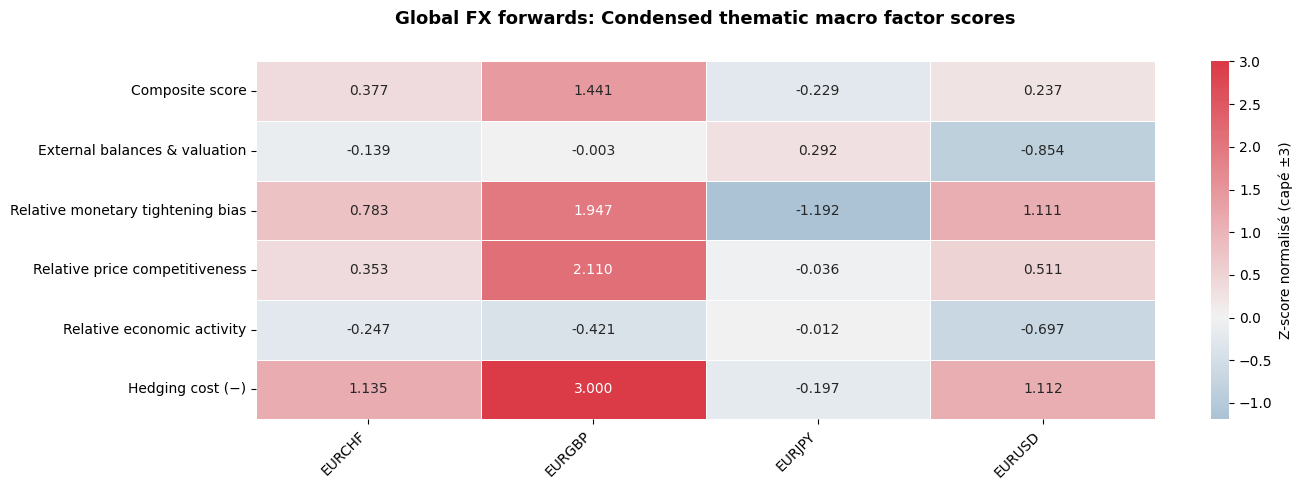

In [7]:
# ================================
# FX Scoreboard — Heatmap snapshot
# ================================
# Lit data/signals_panel.csv, prend la dernière obs par paire,
# calcule un "Composite" (moyenne des facteurs disponibles),
# puis trace une heatmap et écrit un CSV snapshot.

import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def find_project_root(start=Path('.'), markers=("data", ".git", "pyproject.toml", "README.md")):
    p = Path(start).resolve()
    for _ in range(10):
        if any((p / m).exists() for m in markers):
            return p
        if p.parent == p:
            break
        p = p.parent
    return Path.cwd()

DATA_DIR = Path(os.environ.get('FX_DATA_DIR') or os.environ.get('DATA_DIR') or find_project_root() / 'data').expanduser().resolve()
SIG_FILE = DATA_DIR / "signals_panel.csv"
assert SIG_FILE.exists(), f"signals_panel.csv introuvable: {SIG_FILE}"

df = pd.read_csv(SIG_FILE, parse_dates=["Date"]).sort_values(["pair","Date"])

# Facteurs que l'on veut afficher
factor_cols = ["ValueScore","CarryScore","MomentumScore","MacroScore","HedgeCostScore"]

# On garde uniquement les colonnes qui existent vraiment dans le fichier
factor_cols = [c for c in factor_cols if c in df.columns]

# === 1) Dernière valeur non-NaN par paire et par facteur ===
latest_dict = {}
df_sorted = df.sort_values(["pair","Date"])

for col in factor_cols:
    latest_dict[col] = (
        df_sorted
        .groupby("pair")[col]
        .apply(lambda s: s.dropna().iloc[-1] if s.notna().any() else np.nan)
    )

latest = pd.DataFrame(latest_dict)

# === 2) Composite = moyenne des facteurs disponibles ===
latest["Composite"] = latest[factor_cols].mean(axis=1)

# === 3) Construction de la matrice pour la heatmap ===
rename_map = {
    "Composite": "Composite score",
    "MacroScore": "Relative economic activity",
    "CarryScore": "Relative monetary tightening bias",
    "ValueScore": "External balances & valuation",
    "MomentumScore": "Relative price competitiveness",
    "HedgeCostScore": "Hedging cost (−)"
}

row_order = ["Composite"] + factor_cols
mat = latest[row_order].T
mat.index = [rename_map.get(i, i) for i in mat.index]

# Cap visuel
mat = mat.clip(-3, 3)

# Export snapshot CSV
snap_csv = DATA_DIR / "fx_scoreboard_snapshot.csv"
mat.to_csv(snap_csv)

# === 4) Plot heatmap ===
plt.figure(figsize=(14, 5))
ax = plt.gca()
cmap = sns.diverging_palette(240, 10, as_cmap=True)

sns.heatmap(
    mat,
    cmap=cmap,
    center=0,
    annot=True,
    fmt=".3f",
    linewidths=0.5,
    cbar_kws={"label": "Z-score normalisé (capé ±3)"},
    ax=ax
)

ax.set_title(
    "Global FX forwards: Condensed thematic macro factor scores\n",
    fontsize=13, fontweight="bold", pad=12
)
ax.set_xlabel("")
ax.set_ylabel("")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()

png_path = DATA_DIR / "fx_scoreboard_heatmap_v2.png"
plt.savefig(png_path, dpi=300, bbox_inches="tight")

print("Snapshot CSV :", snap_csv)
print("Heatmap PNG  :", png_path)